In [ ]:
# Iterative Construction of a Penalised Vine Structure
This notebook iteratively estimate the quantile.

#### Libraries

In [1]:
import openturns as ot
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

random_state = 123
np.random.seed(random_state)

#### Model function
This example consider the simple additive example.

In [2]:
from dependence.tests import func_overflow, margins_overflow, var_names_overflow, func_sum
from dependence.tests.test_functions import func_prod
from dependence import iterative_vine_minimize

test_func = func_sum

#### Dimension and margins
We first define the problem dimension and the margins

In [3]:
if test_func == func_overflow:
    margins = margins_overflow
    dim = len(margins)
else:
    dim = 2
    margins = [ot.Normal()]*dim

We chose the coefficients of the variables throught the additive function.

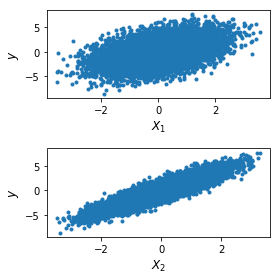

In [4]:
if test_func in [func_sum, func_prod]:
    #coeficients = np.logspace(0., 3., dim+1, endpoint=False)[1:]
    #coeficients /= coeficients.max()
    coeficients = np.asarray(range(1, dim+1))
    new_test_func = lambda x: test_func(x, coeficients)

    n_plot = 10000
    x = np.asarray(ot.ComposedDistribution(margins).getSample(n_plot))
    y = new_test_func(x)    

    fig, axes = plt.subplots(dim, 1, sharex=False, sharey=True, figsize=(4, 2*dim))
    for i in range(dim):
        ax = axes[i]
        ax.plot(x[:, i], y, '.')
        ax.set_xlabel(r'$X_{%d}$' % (i+1), fontsize=12)
        ax.set_ylabel(r'$y$', fontsize=12)
    fig.tight_layout()
else:
    new_test_func = test_func

#### Copula families
We now consider only Gaussian dependencies for this example

In [5]:
families = np.zeros((dim, dim), dtype=int)
for i in range(1, dim):
    for j in range(i):
        families[i, j] = 1

## Estimations
We create an instance of the main class for conservative estimate, and we define a q_func object for the quantile as a quantity of interest

In [6]:
from dependence import ConservativeEstimate, quantile_func

alpha = 0.95

quant_estimate = ConservativeEstimate(model_func=new_test_func, margins=margins, families=families)

In [134]:
n = 5000
X = np.random.uniform(-1, 1., n)[:, np.newaxis]
y = f(X).ravel()

In [135]:
from skgarden import RandomForestQuantileRegressor, MondrianForestRegressor
n_estimators = 500
min_samples_split = 100

rfm = MondrianForestRegressor(n_estimators, bootstrap=True, min_samples_split=min_samples_split, n_jobs=-1)
rfm.fit(X, y)

rfq = RandomForestQuantileRegressor(n_estimators, criterion='mae', bootstrap=True, min_samples_split=min_samples_split, n_jobs=-1)
rfq.fit(X, y)

RandomForestQuantileRegressor(bootstrap=True, criterion='mae', max_depth=None,
               max_features='auto', max_leaf_nodes=None,
               min_samples_leaf=1, min_samples_split=100,
               min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
               oob_score=False, random_state=None, verbose=0,
               warm_start=False)

In [139]:
alpha = 0.05
n_plot = 100
x_plot = np.linspace(-0.9999, 0.9999, n_plot)[:, np.newaxis]
y_pred_rfm, y_std = rfm.predict(x_plot, return_std=True)
q_rfm = []
for mean, std in zip(y_pred_rfm, y_std):
    q_rfm.append(ot.Normal(mean, std).computeQuantile(alpha)[0])
    
q_rfm = np.asarray(q_rfm)
q_rfq = rfq.predict(x_plot, quantile=alpha*100)

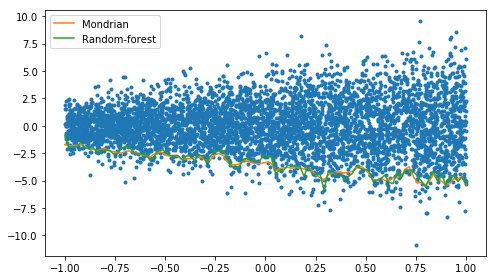

In [140]:
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(X, y, '.')
ax.plot(x_plot, q_rfm, label='Mondrian')
ax.plot(x_plot, q_rfq, label='Random-forest')
ax.legend(loc=0)
fig.tight_layout()

In [142]:
x_plot[q_rfq.argmin()]

array([ 0.2929])

In [157]:
from sklearn.ensemble import RandomForestRegressor

In [191]:
from skgarden import RandomForestQuantileRegressor

class ModifiedRandomForestQuantileRegressor(RandomForestQuantileRegressor):
    def predict(self, X, return_std=False):
        """
        """
        alpha = 0.05
        n_sample = X.shape[0]
        n_estimators = self.n_estimators
        pred = np.zeros((n_estimators, n_sample))
        for i, tree in enumerate(self.estimators_):
            pred[i] = tree.predict(X, quantile=alpha*100)
            
        mean = pred.mean(axis=0)
        if return_std:
            std = pred.std(axis=0)
            return mean, std
        else:
            return mean
        
regf = ModifiedRandomForestQuantileRegressor(n_estimators, min_samples_split=50)

In [192]:
from skopt import forest_minimize

f = lambda x: quant_estimate.stochastic_function(x, 1, return_input_sample=False)
res = forest_minimize(f,                  # the function to minimize
                  [(-0.99999, 0.99999)],      # the bounds on each dimension of x
                      base_estimator=regf,
                  acq_func="LCB",      # the acquisition function
                  n_calls=1010,         # the number of evaluations of f 
                  n_random_starts=1000,  # the number of random initialization points
                  random_state=123,
                  verbose=True,
                  n_jobs=7)   # the random seed

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0157
Function value obtained: -3.6530
Current minimum: -3.6530
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0141
Function value obtained: 1.9845
Current minimum: -3.6530
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0140
Function value obtained: 1.9090
Current minimum: -3.6530
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0136
Function value obtained: -0.3072
Current minimum: -3.6530
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.0141
Function value obtained: -0.9192
Current minimum: -3.6530
Iteration No: 6 started. Ev

Function value obtained: 0.8138
Current minimum: -3.6530
Iteration No: 47 started. Evaluating function at random point.
Iteration No: 47 ended. Evaluation done at random point.
Time taken: 0.0139
Function value obtained: -0.7820
Current minimum: -3.6530
Iteration No: 48 started. Evaluating function at random point.
Iteration No: 48 ended. Evaluation done at random point.
Time taken: 0.0169
Function value obtained: 2.6066
Current minimum: -3.6530
Iteration No: 49 started. Evaluating function at random point.
Iteration No: 49 ended. Evaluation done at random point.
Time taken: 0.0172
Function value obtained: 0.0630
Current minimum: -3.6530
Iteration No: 50 started. Evaluating function at random point.
Iteration No: 50 ended. Evaluation done at random point.
Time taken: 0.0136
Function value obtained: 0.8609
Current minimum: -3.6530
Iteration No: 51 started. Evaluating function at random point.
Iteration No: 51 ended. Evaluation done at random point.
Time taken: 0.0136
Function value obta

Iteration No: 206 ended. Evaluation done at random point.
Time taken: 0.0134
Function value obtained: -1.4037
Current minimum: -6.6242
Iteration No: 207 started. Evaluating function at random point.
Iteration No: 207 ended. Evaluation done at random point.
Time taken: 0.0135
Function value obtained: 1.4803
Current minimum: -6.6242
Iteration No: 208 started. Evaluating function at random point.
Iteration No: 208 ended. Evaluation done at random point.
Time taken: 0.0135
Function value obtained: -1.7646
Current minimum: -6.6242
Iteration No: 209 started. Evaluating function at random point.
Iteration No: 209 ended. Evaluation done at random point.
Time taken: 0.0136
Function value obtained: 1.5812
Current minimum: -6.6242
Iteration No: 210 started. Evaluating function at random point.
Iteration No: 210 ended. Evaluation done at random point.
Time taken: 0.0135
Function value obtained: 2.8897
Current minimum: -6.6242
Iteration No: 211 started. Evaluating function at random point.
Iteratio

Function value obtained: 2.2973
Current minimum: -6.6242
Iteration No: 318 started. Evaluating function at random point.
Iteration No: 318 ended. Evaluation done at random point.
Time taken: 0.0139
Function value obtained: 2.1007
Current minimum: -6.6242
Iteration No: 319 started. Evaluating function at random point.
Iteration No: 319 ended. Evaluation done at random point.
Time taken: 0.0139
Function value obtained: 1.6160
Current minimum: -6.6242
Iteration No: 320 started. Evaluating function at random point.
Iteration No: 320 ended. Evaluation done at random point.
Time taken: 0.0140
Function value obtained: 2.3261
Current minimum: -6.6242
Iteration No: 321 started. Evaluating function at random point.
Iteration No: 321 ended. Evaluation done at random point.
Time taken: 0.0139
Function value obtained: 0.6789
Current minimum: -6.6242
Iteration No: 322 started. Evaluating function at random point.
Iteration No: 322 ended. Evaluation done at random point.
Time taken: 0.0175
Function v

Time taken: 0.0139
Function value obtained: 1.5020
Current minimum: -6.6242
Iteration No: 505 started. Evaluating function at random point.
Iteration No: 505 ended. Evaluation done at random point.
Time taken: 0.0138
Function value obtained: 4.3955
Current minimum: -6.6242
Iteration No: 506 started. Evaluating function at random point.
Iteration No: 506 ended. Evaluation done at random point.
Time taken: 0.0139
Function value obtained: -3.1297
Current minimum: -6.6242
Iteration No: 507 started. Evaluating function at random point.
Iteration No: 507 ended. Evaluation done at random point.
Time taken: 0.0139
Function value obtained: -1.3112
Current minimum: -6.6242
Iteration No: 508 started. Evaluating function at random point.
Iteration No: 508 ended. Evaluation done at random point.
Time taken: 0.0139
Function value obtained: -1.2892
Current minimum: -6.6242
Iteration No: 509 started. Evaluating function at random point.
Iteration No: 509 ended. Evaluation done at random point.
Time ta

Iteration No: 617 ended. Evaluation done at random point.
Time taken: 0.0135
Function value obtained: -1.3315
Current minimum: -8.9450
Iteration No: 618 started. Evaluating function at random point.
Iteration No: 618 ended. Evaluation done at random point.
Time taken: 0.0135
Function value obtained: -0.6873
Current minimum: -8.9450
Iteration No: 619 started. Evaluating function at random point.
Iteration No: 619 ended. Evaluation done at random point.
Time taken: 0.0135
Function value obtained: -6.2569
Current minimum: -8.9450
Iteration No: 620 started. Evaluating function at random point.
Iteration No: 620 ended. Evaluation done at random point.
Time taken: 0.0135
Function value obtained: 0.2050
Current minimum: -8.9450
Iteration No: 621 started. Evaluating function at random point.
Iteration No: 621 ended. Evaluation done at random point.
Time taken: 0.0135
Function value obtained: 0.1926
Current minimum: -8.9450
Iteration No: 622 started. Evaluating function at random point.
Iterati

Iteration No: 803 started. Evaluating function at random point.
Iteration No: 803 ended. Evaluation done at random point.
Time taken: 0.0140
Function value obtained: 0.8882
Current minimum: -8.9450
Iteration No: 804 started. Evaluating function at random point.
Iteration No: 804 ended. Evaluation done at random point.
Time taken: 0.0139
Function value obtained: -2.3375
Current minimum: -8.9450
Iteration No: 805 started. Evaluating function at random point.
Iteration No: 805 ended. Evaluation done at random point.
Time taken: 0.0140
Function value obtained: 3.4141
Current minimum: -8.9450
Iteration No: 806 started. Evaluating function at random point.
Iteration No: 806 ended. Evaluation done at random point.
Time taken: 0.0183
Function value obtained: 0.8116
Current minimum: -8.9450
Iteration No: 807 started. Evaluating function at random point.
Iteration No: 807 ended. Evaluation done at random point.
Time taken: 0.0137
Function value obtained: 1.3690
Current minimum: -8.9450
Iteration

Current minimum: -8.9450
Iteration No: 992 started. Evaluating function at random point.
Iteration No: 992 ended. Evaluation done at random point.
Time taken: 0.0129
Function value obtained: 0.9897
Current minimum: -8.9450
Iteration No: 993 started. Evaluating function at random point.
Iteration No: 993 ended. Evaluation done at random point.
Time taken: 0.0130
Function value obtained: 2.0138
Current minimum: -8.9450
Iteration No: 994 started. Evaluating function at random point.
Iteration No: 994 ended. Evaluation done at random point.
Time taken: 0.0129
Function value obtained: 0.0487
Current minimum: -8.9450
Iteration No: 995 started. Evaluating function at random point.
Iteration No: 995 ended. Evaluation done at random point.
Time taken: 0.0131
Function value obtained: 2.0763
Current minimum: -8.9450
Iteration No: 996 started. Evaluating function at random point.
Iteration No: 996 ended. Evaluation done at random point.
Time taken: 0.0129
Function value obtained: -0.9609
Current m

In [193]:
rf = res.models[-1]

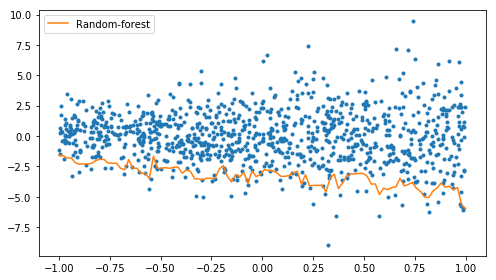

In [194]:
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(res.x_iters, res.func_vals, '.')
ax.plot(x_plot, rf.predict(x_plot), label='Random-forest')
ax.legend(loc=0)
fig.tight_layout()

In [195]:
"x^*=%.4f, f(x^*)=%.4f" % (res.x[0], res.fun)

'x^*=0.3223, f(x^*)=-8.9450'

In [143]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
kernel = 1.0 * RBF(length_scale=1., length_scale_bounds=(1e-2, 1e3)) \
    + WhiteKernel(noise_level=2., noise_level_bounds=(1e-10, 10.))
    
gp = GaussianProcessRegressor(kernel=kernel,
                              alpha=0.1).fit(X, y)

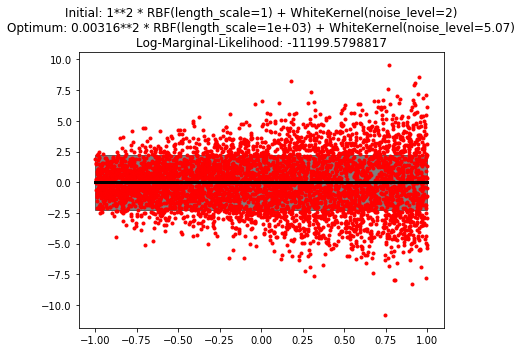

In [144]:
X_ = np.linspace(-1., 1., 100)
y_mean, y_cov = gp.predict(X_[:, np.newaxis], return_cov=True)

fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(X[:, 0], y, 'r.')
ax.plot(X_, y_mean, 'k', lw=3, zorder=9)
ax.fill_between(X_, y_mean - np.sqrt(np.diag(y_cov)),
                 y_mean + np.sqrt(np.diag(y_cov)),
                 alpha=0.5, color='k')
ax.set_title("Initial: %s\nOptimum: %s\nLog-Marginal-Likelihood: %s"
          % (kernel, gp.kernel_,
             gp.log_marginal_likelihood(gp.kernel_.theta)))
fig.tight_layout()

In [61]:
from sklearn.gaussian_process import GaussianProcessRegressor

gp = GaussianProcessRegressor(alpha=1)
gp.fit(X, y)

GaussianProcessRegressor(alpha=1, copy_X_train=True, kernel=None,
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

In [63]:
y_gp, std_gp = gp.predict(x_plot, return_std=True)

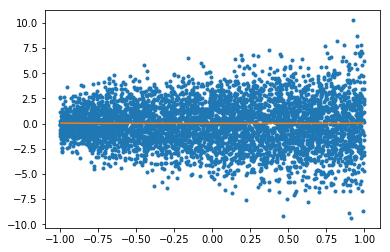

In [65]:
plt.plot(X, y, '.')
plt.plot(x_plot, std_gp)

First, we compute the quantile at independence

In [66]:
n = 10000
indep_result = quant_estimate.independence(n_input_sample=n, q_func=q_func, random_state=random_state)

In [67]:
indep_result.compute_bootstrap(1000)
boot_std = indep_result.bootstrap_sample.std()
boot_mean = indep_result.bootstrap_sample.mean()
print('Quantile at independence: %.2f with a C.O.V at %.1f %%' % (boot_mean, abs(boot_std/boot_mean)*100.))

Quantile at independence: -1.63 with a C.O.V at 1.3 %


In [68]:
algorithm_parameters = {
    "n_input_sample": 10000,
    "n_dep_param_init": 10,
    "max_n_pairs": 1,
    "grid_type": 'lhs',
    "q_func": q_func,
    "n_add_pairs": 1,
    "n_remove_pairs": 0,
    "adapt_vine_structure": True,
    "with_bootstrap": False,
    "verbose": False,
    "iterative_save": False,
    "iterative_load": False,
    "load_input_samples": False,
    "keep_input_samples": False
}

quant_estimate = ConservativeEstimate(model_func=new_test_func, margins=margins, families=families)

iterative_results = iterative_vine_minimize(estimate_object=quant_estimate, **algorithm_parameters)

AssertionError: Must add at least one pair at each iteration

In [69]:
from dependence.dependence_plot import matrix_plot_quantities
results = iterative_results[0]
matrix_plot_quantities(results, figsize=(18, 15))
# plt.savefig('output/matrix_plot.png')

NameError: name 'iterative_results' is not defined

### Iterative Approach
Now lets see how good we can be with the iterative appraoch.

In [20]:
algorithm_parameters = {
    "n_input_sample": 10000,
    "n_dep_param_init": 20,
    "max_n_pairs": 3,
    "grid_type": 'vertices',
    "q_func": q_func,
    "n_add_pairs": 2,
    "n_remove_pairs": 7,
    "adapt_vine_structure": False,
    "with_bootstrap": False,
    "verbose": True,
    "iterative_save": False,
    "iterative_load": False,
    "load_input_samples": False,
    "keep_input_samples": False,
    "input_names": var_names_overflow
}

quant_estimate = ConservativeEstimate(model_func=new_test_func, margins=margins, families=families)

iterative_results = iterative_vine_minimize(estimate_object=quant_estimate, **algorithm_parameters)

n=10000. Worst quantile of [(1, 0)] at -1.8365542554541638
The variables are: K_s-Q
n=10000. Worst quantile of [(2, 0)] at -1.8245302264434484
The variables are: Z_v-Q
n=10000. Worst quantile of [(2, 1)] at -1.8658454406628129
The variables are: Z_v-K_s
n=10000. Worst quantile of [(3, 0)] at -1.8948356176617809
The variables are: Z_m-Q
n=10000. Worst quantile of [(3, 1)] at -1.8897021464935606
The variables are: Z_m-K_s
n=10000. Worst quantile of [(3, 2)] at -1.8746482861346154
The variables are: Z_m-Z_v
n=10000. Worst quantile of [(4, 0)] at -1.8692452915370747
The variables are: H_d-Q
n=10000. Worst quantile of [(4, 1)] at -1.84057992389644
The variables are: H_d-K_s
n=10000. Worst quantile of [(4, 2)] at -1.8764223127288653
The variables are: H_d-Z_v
n=10000. Worst quantile of [(4, 3)] at -1.868190935451335
The variables are: H_d-Z_m
n=10000. Worst quantile of [(5, 0)] at -1.8704323637793827
The variables are: C_b-Q
n=10000. Worst quantile of [(5, 1)] at -1.8522220859479948
The vari

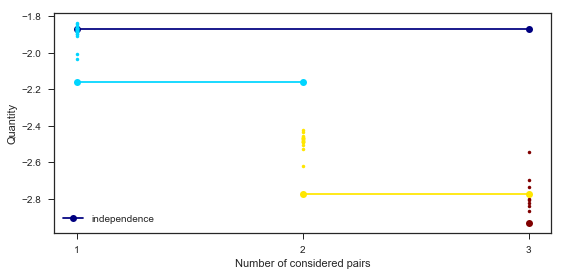

In [17]:
from dependence.dependence_plot import plot_iterative_results, matrix_plot_input

plot_iterative_results(iterative_results, indep_result=indep_result, q_func=q_func)

In [18]:
n = 10000
K = 300
quant_estimate.vine_structure = None
grid_results = quant_estimate.gridsearch(n_dep_param=K, n_input_sample=n, q_func=q_func, grid_type='vertices')

In [19]:
min_result = grid_results.min_result
print(min_result.quantity)

-3.0746765451805227


In [ ]:
from dependence.dependence_plot import matrix_plot_input
matrix_plot_input(min_result, margins=margins)

In [46]:
from dependence.utils import get_pair_id, get_pairs_by_levels, get_possible_structures
pairs_iter = [[1, 0]]
pairs_iter_id = [get_pair_id(dim, pair, with_plus=False) for pair in pairs_iter]
pairs_by_levels = get_pairs_by_levels(dim, pairs_iter_id)
quant_estimate.vine_structure = get_possible_structures(dim, pairs_by_levels)[0]
quant_estimate.vine_structure

array([[2, 0, 0, 0, 0, 0, 0, 0],
       [8, 1, 0, 0, 0, 0, 0, 0],
       [7, 8, 3, 0, 0, 0, 0, 0],
       [6, 7, 8, 4, 0, 0, 0, 0],
       [5, 6, 7, 8, 5, 0, 0, 0],
       [4, 5, 6, 7, 8, 6, 0, 0],
       [3, 4, 5, 6, 7, 8, 7, 0],
       [1, 3, 4, 5, 6, 7, 8, 8]])

In [47]:
grid_results = quant_estimate.gridsearch(n_dep_param=K, n_input_sample=n, q_func=q_func)

In [48]:
min_result = grid_results.min_result
print(min_result.quantity)

-0.5385555538636204


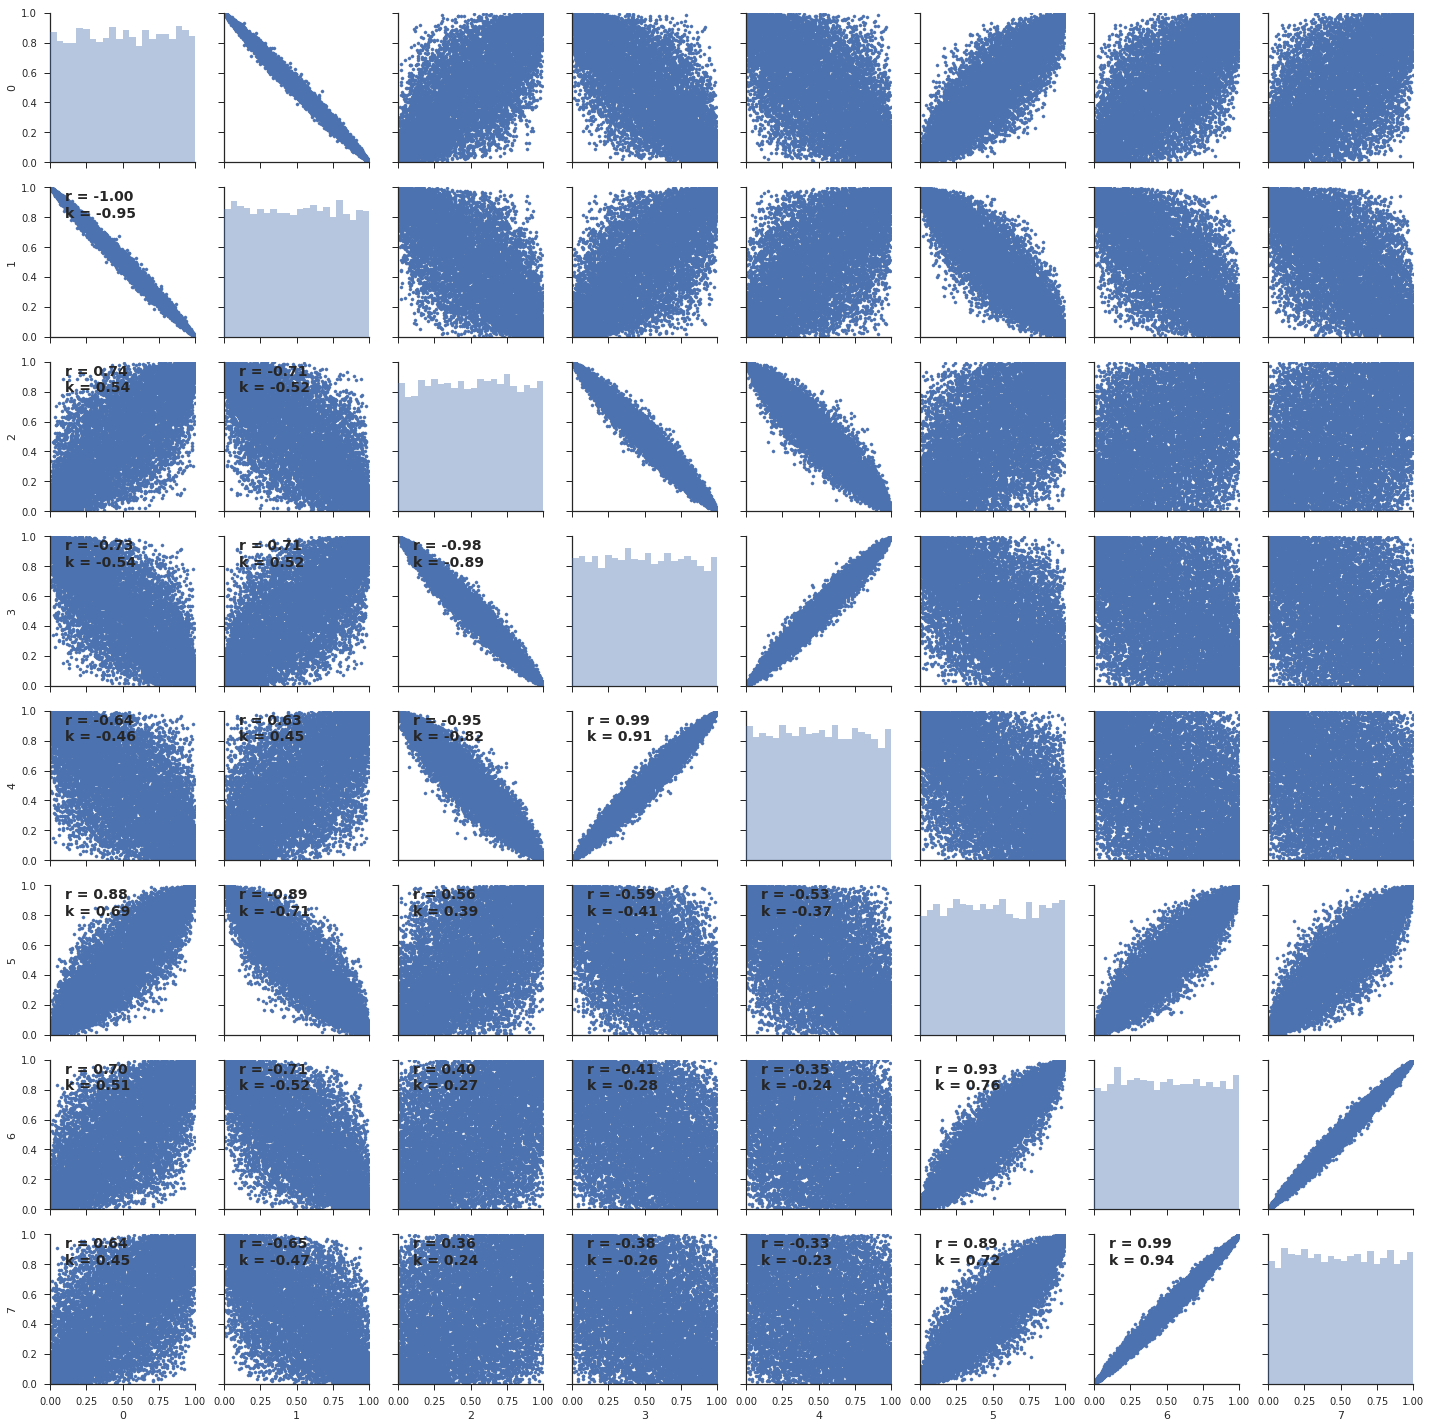

In [49]:
from dependence.dependence_plot import matrix_plot_input
matrix_plot_input(min_result, margins=margins)